In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import torch
from matplotlib import pyplot as plt

from counterfactuals.datasets import AuditDataset
from counterfactuals.losses import BinaryDiscLoss
from counterfactuals.cf_methods.group_ppcef.rppcef import RPPCEF
from counterfactuals.generative_models import MaskedAutoregressiveFlow
from counterfactuals.discriminative_models import (
    LogisticRegression,
    MultilayerPerceptron,
)
from counterfactuals.metrics import CFMetrics

from counterfactuals.plot_utils import plot_generative_model_distribution

/Users/ofurman/Private/counterfactuals/venv/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [124]:
# dataset = MnistDataset("../data/mnist.csv")
# dataset = LawDataset("../data/law.csv")
# dataset = HelocDataset("../data/heloc.csv")
dataset = AuditDataset("../data/audit.csv")

In [125]:
disc_model = MultilayerPerceptron(dataset.X_test.shape[1], [512, 512], 1)
# disc_model.fit(
#     dataset.train_dataloader(batch_size=128, shuffle=True),
#     dataset.test_dataloader(batch_size=128, shuffle=False),
#     epochs=5000,
#     patience=100,
#     lr=1e-3,
#     checkpoint_path="disc_model.pt",
# )
disc_model.load("disc_model.pt")

/Users/ofurman/Private/counterfactuals/counterfactuals/discriminative_models/multilayer_perceptron.py:109: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  self.load_state_dict

In [114]:
disc_model = LogisticRegression(dataset.X_test.shape[1], 1)
disc_model.fit(
    dataset.train_dataloader(batch_size=256, shuffle=True),
    dataset.test_dataloader(batch_size=256, shuffle=False),
    epochs=5000,
    patience=100,
    checkpoint_path="disc_model.pt",
)
# disc_model.load("disc_model.pt")

Epoch 2654, Train: 0.0822, test: 0.0885, patience: 100:  53%|█████▎    | 2654/5000 [00:06<00:06, 381.66it/s]
/Users/ofurman/Private/counterfactuals/counterfactuals/discriminative_models/logistic_regression.py:87: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. 

In [126]:
y_pred = disc_model.predict(dataset.X_test).detach().numpy().flatten()
print("Test accuracy:", (y_pred == dataset.y_test).mean())

Test accuracy: 0.9508196721311475


In [127]:
dataset.y_train = disc_model.predict(dataset.X_train).detach().numpy()
dataset.y_test = disc_model.predict(dataset.X_test).detach().numpy()

In [128]:
# dataset = MoonsDataset("../data/moons.csv")
# dataset = MnistDataset("../data/mnist.csv")
# train_dataloader = dataset.train_dataloader(batch_size=1024, shuffle=True)
# test_dataloader = dataset.test_dataloader(batch_size=1024, shuffle=False)

# disc_model = LogisticRegression(dataset.X_test.shape[1], 1)
# disc_model.fit(
#     dataset.train_dataloader(batch_size=1024, shuffle=True),
#     dataset.test_dataloader(batch_size=1024, shuffle=False),
#     epochs=1000
# )

gen_model = MaskedAutoregressiveFlow(
    features=dataset.X_train.shape[1],
    hidden_features=16,
    num_blocks_per_layer=2,
    num_layers=5,
    context_features=1,
    batch_norm_within_layers=True,
    batch_norm_between_layers=True,
    use_random_permutations=True,
)
train_dataloader = dataset.train_dataloader(
    batch_size=256, shuffle=True, noise_lvl=0.03
)
test_dataloader = dataset.test_dataloader(batch_size=256, shuffle=False)

# gen_model.fit(
#     train_dataloader,
#     train_dataloader,
#     learning_rate=1e-5,
#     patience=30,
#     num_epochs=300,
#     checkpoint_path="flow.pth"
# )
gen_model.load("flow.pth")

/Users/ofurman/Private/counterfactuals/counterfactuals/generative_models/maf/maf.py:154: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  self.load_state_dict(torch.load(path))

In [129]:
# with torch.no_grad():
#     plt.imshow(gen_model.sample_and_log_prob(1, context=torch.tensor([1.0]))[0].view(28, 28).detach().numpy(), cmap="gray")

In [130]:
# plt.imshow(dataset.X_train[6].reshape(28, 28), cmap="gray")

In [131]:
source_class = 1
target_class = 0
X_test_origin = dataset.X_test[dataset.y_test == source_class]
y_test_origin = dataset.y_test[dataset.y_test == source_class]

In [132]:
cf_method = RPPCEF(
    X=X_test_origin,
    cf_method_type="GCE",
    K=6,
    gen_model=gen_model,
    disc_model=disc_model,
    disc_model_criterion=BinaryDiscLoss(),
    actionable_features=dataset.not_actionable_features,
    neptune_run=None,
)

In [133]:
train_dataloader_for_log_prob = dataset.train_dataloader(batch_size=4096, shuffle=False)
log_prob_threshold = torch.quantile(
    gen_model.predict_log_prob(train_dataloader_for_log_prob),
    0.25,
)

cf_dataloader = torch.utils.data.DataLoader(
    torch.utils.data.TensorDataset(
        torch.tensor(X_test_origin).float(),
        torch.tensor(y_test_origin).float(),
    ),
    batch_size=4096,
    shuffle=False,
)


delta, Xs, ys_orig, ys_target = cf_method.explain_dataloader(
    dataloader=cf_dataloader,
    epochs=20000,
    lr=0.003,
    patience=1000,
    alpha=100,
    alpha_s=100,
    alpha_k=100,
    log_prob_threshold=log_prob_threshold,
)

loss: 817.8766, dist: 1.2451, max_inner: 5.3198, loss_disc: 2.7454, delta_loss: 10.1168: 100%|██████████| 20000/20000 [01:23<00:00, 238.60it/s]


In [134]:
M, S, D = delta.get_matrices()

In [135]:
S.sum(axis=0)

tensor([ 0.0000,  0.0000, 58.7516,  0.0000,  1.2484,  0.0000],
       grad_fn=<SumBackward1>)

In [136]:
D

Parameter containing:
tensor([[ -0.1476,  -0.1541,  -0.1030,  -0.1408,  -0.1519,   0.1538,   0.0000,
           0.0000,   0.0000,   0.0000,   0.0000,   0.0000,   0.0000,   0.0000,
           0.0000,   0.0000,   0.0000,   0.0000,   0.0000,   0.0000,   0.0000,
           0.0000,   0.0000],
        [ -0.1474,  -0.1538,  -0.1039,  -0.1405,  -0.1514,   0.1534,   0.0000,
           0.0000,   0.0000,   0.0000,   0.0000,   0.0000,   0.0000,   0.0000,
           0.0000,   0.0000,   0.0000,   0.0000,   0.0000,   0.0000,   0.0000,
           0.0000,   0.0000],
        [ -0.1076,  -0.5439,  -0.0673,  -0.0930,  -0.4263,   0.0937,   0.0000,
           0.0000,   0.0000,   0.0000,   0.0000,   0.0000,   0.0000,   0.0000,
           0.0000,   0.0000,   0.0000,   0.0000,   0.0000,   0.0000,   0.0000,
           0.0000,   0.0000],
        [ -0.1477,  -0.1541,  -0.1064,  -0.1405,  -0.1515,   0.1537,   0.0000,
           0.0000,   0.0000,   0.0000,   0.0000,   0.0000,   0.0000,   0.0000,
           0.0000, 

In [137]:
values, indexes = S.max(dim=1)

total = len(values)
i_correct = indexes[values == 1]
print(f"Correct: {len(i_correct)}/{total}")
print(len(set(i_correct.tolist())))

Correct: 51/60
2


In [138]:
Xs_cfs = Xs + delta().detach().numpy()

In [139]:
y_pred = disc_model.predict(Xs_cfs).detach().numpy().flatten()
print("Test accuracy:", (y_pred == ys_target).mean())

Test accuracy: 0.0


In [140]:
metrics = CFMetrics(
    X_cf=Xs_cfs,
    y_target=ys_target,
    X_train=dataset.X_train,
    y_train=dataset.y_train,
    X_test=X_test_origin,
    y_test=y_test_origin,
    disc_model=disc_model,
    gen_model=gen_model,
    continuous_features=list(range(dataset.X_train.shape[1])),
    categorical_features=dataset.categorical_features,
    prob_plausibility_threshold=log_prob_threshold,
)

In [141]:
metrics.calc_all_metrics()

/Users/ofurman/Private/counterfactuals/venv/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/ofurman/Private/counterfactuals/venv/lib/python3.9/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


{'coverage': 1.0,
 'validity': 0.0,
 'actionability': 0.0,
 'sparsity': 0.2608695652173913,
 'proximity_categorical_hamming': nan,
 'proximity_categorical_jaccard': nan,
 'proximity_continuous_manhattan': nan,
 'proximity_continuous_euclidean': nan,
 'proximity_continuous_mad': nan,
 'proximity_l2_jaccard': nan,
 'proximity_mad_hamming': nan,
 'prob_plausibility': 0.48333333333333334,
 'log_density_cf': 4.9419456,
 'log_density_test': -14.947046,
 'lof_scores_cf': 18.277517,
 'lof_scores_test': 1.3236046,
 'isolation_forest_scores_cf': -0.012504135081959676,
 'isolation_forest_scores_test': 0.024339243408723746}

In [142]:
import pandas as pd

pd.Series(S.argmax(dim=1)).value_counts()

2    59
4     1
Name: count, dtype: int64

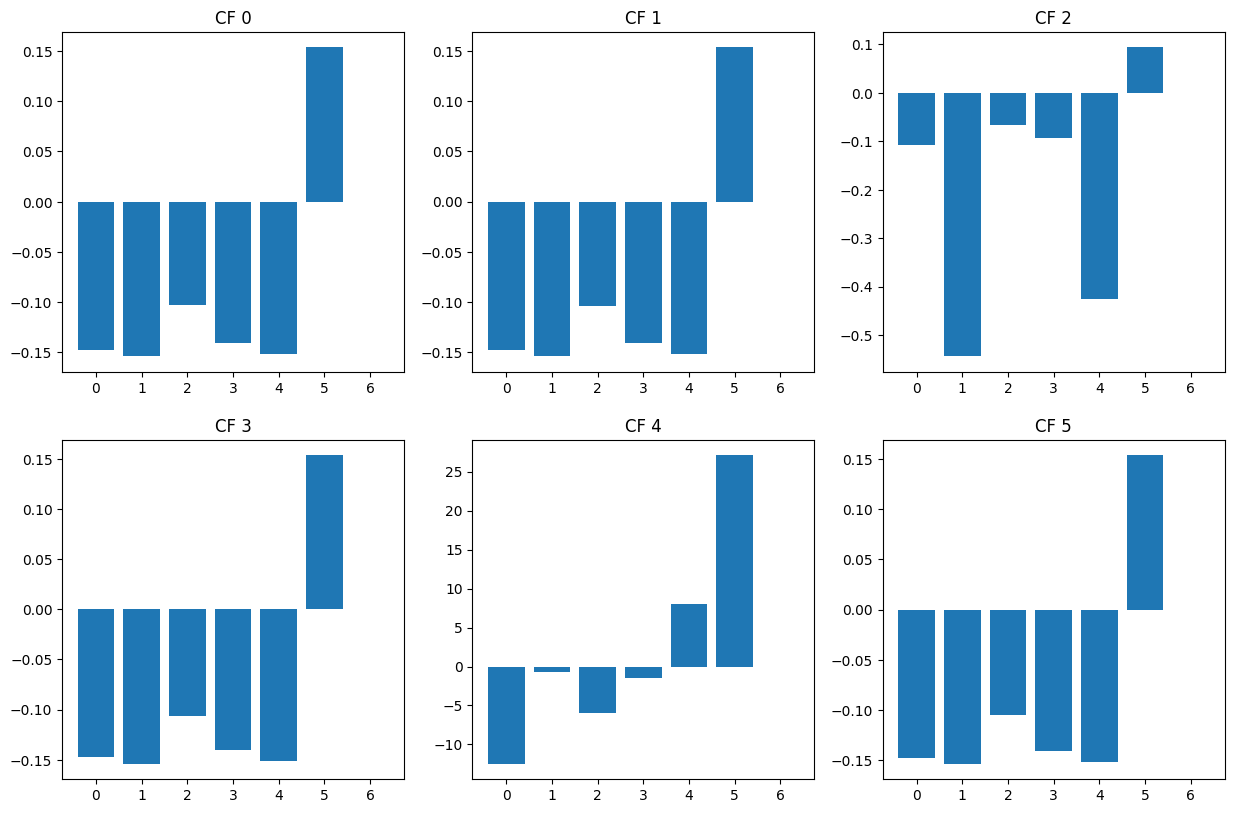

In [143]:
plt.figure(figsize=(15, 15))
for i in range(6):
    plt.subplot(3, 3, i + 1)
    plt.bar(range(7), D[i, :7].detach().numpy())
    plt.title(f"CF {i}")

<Axes: >

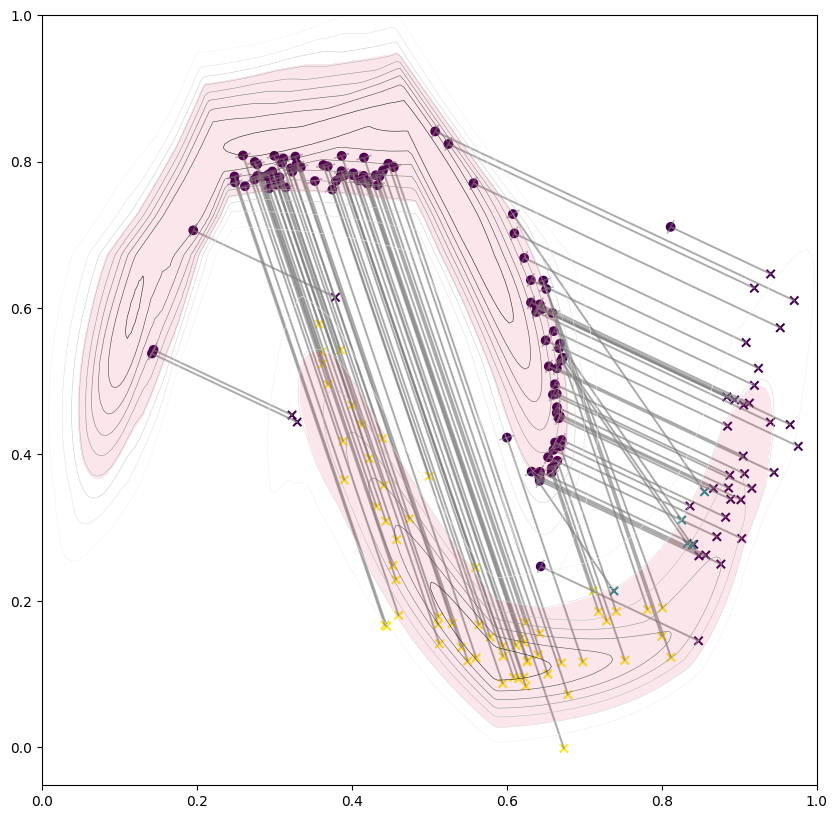

In [83]:
fig, ax = plt.subplots(figsize=(10, 10))
ax.scatter(Xs_cfs[:, 0], Xs_cfs[:, 1], c=ys_target)
ax.scatter(Xs[:, 0], Xs[:, 1], c=indexes, marker="x")

# Add arrows between each Xs and Xs_cfs
for i in range(len(Xs)):
    ax.arrow(
        Xs[i, 0],
        Xs[i, 1],
        Xs_cfs[i, 0] - Xs[i, 0],
        Xs_cfs[i, 1] - Xs[i, 1],
        head_width=0.02,
        head_length=0.00,
        fc="gray",
        ec="gray",
        alpha=0.5,
    )

plot_generative_model_distribution(ax, gen_model, log_prob_threshold, 2)

In [8]:
# options = [
#     {"K": 1, "alpha_plausability": 0, "alpha_search": 0},
#     {"K": max_samples, "alpha_plausability": 0, "alpha_search": 0},
#     {"K": max_samples, "alpha_plausability": 0, "alpha_search": 1000},
#     {"K": 1, "alpha_plausability": 1000, "alpha_search": 0},
#     {"K": max_samples, "alpha_plausability": 1000, "alpha_search": 0},
#     {"K": max_samples, "alpha_plausability": 1000, "alpha_search": 1000},
# ]

# for opt in options:
#     print(opt)
#     K = opt["K"]
#     alpha_plausability = opt["alpha_plausability"]
#     alpha_search = opt["alpha_search"]

#     cf = RPPCEF(
#         K=K,
#         gen_model=gen_model,
#         disc_model=disc_model,
#         disc_model_criterion=BinaryDiscLoss(),
#         neptune_run=None,
#     )

#     cf_dataloader = torch.utils.data.DataLoader(
#         torch.utils.data.TensorDataset(
#             torch.from_numpy(dataset.X_test[dataset.y_test == 0]),
#             torch.from_numpy(dataset.y_test[dataset.y_test == 0]),
#         ),
#         batch_size=1024,
#         shuffle=False,
#     )
#     median_log_prob = torch.median(gen_model.predict_log_prob(cf_dataloader))

#     deltas, X_orig, y_orig, y_target, logs = cf.search_batch(
#         cf_dataloader,
#         alpha=1000,
#         alpha_plausability=alpha_plausability,
#         alpha_search=alpha_search,
#         median_log_prob=median_log_prob,
#         epochs=10000,
#     )

#     M, S, D = deltas[0].get_matrices()
#     print(f"Number of vectors: {(S.sum(axis=0) != 0).sum()}")

#     X_cf = X_orig + deltas[0]().detach().numpy()

#     ## Distribution Plot
#     ax = plot_generative_model_distribution(cf.gen_model, median_log_prob, cf.disc_model)

#     ## Classifier Line
#     w1, w2 = list(disc_model.parameters())[0].detach().cpu().numpy()[0]
#     b = list(disc_model.parameters())[1].detach().cpu().numpy().item()
#     c = -b / w2
#     m = -w1 / w2
#     xmin, xmax = -1.5, 2.5
#     ymin, ymax = -1.5, 2.5
#     xd = np.array([xmin, xmax])
#     yd = m * xd + c
#     plt.plot(xd, yd, "#ADD8E6", lw=2.0, ls="dashed")
#     # plt.axis("off")

#     ## Original points
#     ax.scatter(X_orig[:, 0], X_orig[:, 1], alpha=0.5)

#     ## Counterfactuals
#     ax.scatter(X_cf[:, 0], X_cf[:, 1], c="r")

#     for before, after in zip(X_orig, X_cf):
#         ax.arrow(
#             before[0],
#             before[1],
#             after[0] - before[0],
#             after[1] - before[1],
#             # head_width=0.0,
#             # head_length=0.0,
#             fc="gray",
#             ec="gray",
#             alpha=0.5,
#             width=0.0001,
#         )

#     plt.xlim([-0.10, 1.05])
#     plt.ylim([-0.10, 1.10])
#     plt.tight_layout()

#     ## Save Figure
#     plt.savefig(f"K_{K}_Search_{alpha_search}_Plausability_{alpha_plausability}.pdf")
#     plt.close()

{'K': 1, 'alpha_plausability': 0, 'alpha_search': 0}


  0%|                                                                                                         …

Number of vectors: 1


/opt/homebrew/anaconda3/envs/counterfactuals/lib/python3.10/site-packages/torch/functional.py:504: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/aten/src/ATen/native/TensorShape.cpp:3527.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


{'K': 103, 'alpha_plausability': 0, 'alpha_search': 0}


  0%|                                                                                                         …

Number of vectors: 48
{'K': 103, 'alpha_plausability': 0, 'alpha_search': 1000}


  0%|                                                                                                         …

Number of vectors: 5
{'K': 1, 'alpha_plausability': 1000, 'alpha_search': 0}


  0%|                                                                                                         …

Number of vectors: 1
{'K': 103, 'alpha_plausability': 1000, 'alpha_search': 0}


  0%|                                                                                                         …

Number of vectors: 40
{'K': 103, 'alpha_plausability': 1000, 'alpha_search': 1000}


  0%|                                                                                                         …

Number of vectors: 9
